In [21]:
!pip install statsmodels --quiet
!pip install krippendorff

## imports

In [2]:
import torch
import numpy as np
import networkx as nx
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import seaborn as sns
from krippendorff import alpha as kripp_alpha
from sklearn.metrics import cohen_kappa_score
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from statsmodels.stats.inter_rater import fleiss_kappa
from scipy.stats import pearsonr

### Data Loading

In [4]:
triples_df = pd.read_csv("/content/triples_df.csv")
triples_df.head()

,id,text_id,context,relationship,relation,relation_cluster,relation_cluster_label,Dominant Distortion,Secondary Distortion (Optional)
0,0,1,Nobody likes me because I'm not interesting.,"('like', 'Nobody', 'me')",like,1,Interpersonal Beliefs / Emotions,General Distortion,NaN
1,1,9,Nobody cares about me because they didn't ask...,"('care', 'Nobody', 'me')",care,0,Supportive Actions,General Distortion,NaN
2,2,10,My partner didn't say 'I love you' today our ...,"('love', 'I', 'you')",love,1,Interpersonal Beliefs / Emotions,General Distortion,NaN
3,3,12,I didn't get a reply to my email they must ha...,"('hate', 'they', 'me')",hate,1,Interpersonal Beliefs / Emotions,General Distortion,NaN
4,4,23,No one will ever love me because I'm too shy.,"('love', 'one', 'me')",love,1,Interpersonal Beliefs / Emotions,General Distortion,NaN


## Visualizing cluster vs Distortion (Layer 1)

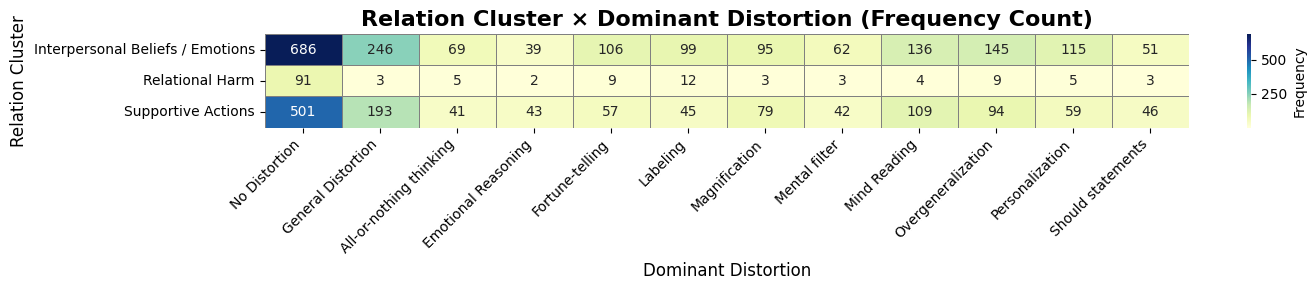

In [5]:
# Step 1: Build the count matrix
verb_dist_matrix = pd.crosstab(
    triples_df["relation_cluster_label"],
    triples_df["Dominant Distortion"]
)

# Step 2: Sort distortions → "No", "General", then alphabetical
def custom_sort(distortions):
    distortions = list(distortions)
    sorted_cols = []
    if 'No Distortion' in distortions:
        sorted_cols.append('No Distortion')
    if 'General Distortion' in distortions:
        sorted_cols.append('General Distortion')
    rest = sorted([d for d in distortions if d not in sorted_cols])
    return sorted_cols + rest

# Step 3: Apply sorting
sorted_rows = sorted(verb_dist_matrix.index)
sorted_cols = custom_sort(verb_dist_matrix.columns)
verb_dist_matrix = verb_dist_matrix.loc[sorted_rows, sorted_cols]

# Step 4: Plot the heatmap
plt.figure(figsize=(len(sorted_cols) * 1.2, len(sorted_rows) * 1.0))  # Scales with data
sns.heatmap(verb_dist_matrix,
            cmap="YlGnBu",
            annot=True,
            fmt='d',
            linewidths=0.5,
            linecolor='gray',
            xticklabels=sorted_cols,
            yticklabels=sorted_rows,
            cbar_kws={"label": "Frequency"})

# Step 5: Customize labels and layout
plt.title("Relation Cluster × Dominant Distortion (Frequency Count)", fontsize=16, fontweight='bold')
plt.xlabel("Dominant Distortion", fontsize=12)
plt.ylabel("Relation Cluster", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

# Computing Agreement Matrics

In [27]:
df = triples_df.copy()

# Get unique relation cluster labels (limit to top 5)
top_relation_clusters = [
     "Supportive Actions",
     "Interpersonal Beliefs / Emotions",
     "Relational Harm"
]

distortions = df['Dominant Distortion'].unique()

results = []

# Loop through all combinations
for cluster in top_relation_clusters:
    vec_cluster = (df['relation_cluster_label'] == cluster).astype(int)

    for distortion in distortions:
        vec_dist = (df['Dominant Distortion'] == distortion).astype(int)

        if vec_dist.sum() < 2:
            continue

        # Krippendorff Alpha
        try:
            data = np.vstack([vec_cluster.values, vec_dist.values])
            k_alpha = kripp_alpha(data, level_of_measurement='nominal')
        except Exception:
            k_alpha = np.nan

        # Fleiss Kappa (using Cohen’s Kappa as approximation for binary)
        try:
            kappa = cohen_kappa_score(vec_cluster, vec_dist)
        except Exception:
            kappa = np.nan

        # Pearson R
        try:
            r, _ = pearsonr(vec_cluster, vec_dist)
        except Exception:
            r = np.nan

        results.append({
            'relation_cluster': cluster,
            'distortion': distortion,
            'kripp_alpha': k_alpha,
            'fleiss_kappa': kappa,
            'pearson_r': r
        })

# Convert to DataFrame
agreement_df = pd.DataFrame(results)

# Sorting and Creating Pivot Tables

In [28]:
# Distortion sorter (No → General → alphabetical)
def custom_sort(distortions):
    distortions = list(distortions)
    sorted_cols = []
    if 'No Distortion' in distortions:
        sorted_cols.append('No Distortion')
    if 'General Distortion' in distortions:
        sorted_cols.append('General Distortion')
    rest = sorted([d for d in distortions if d not in sorted_cols])
    return sorted_cols + rest

# Pivot tables for each metric
alpha_pivot = agreement_df.pivot(index='relation_cluster', columns='distortion', values='kripp_alpha')
kappa_pivot = agreement_df.pivot(index='relation_cluster', columns='distortion', values='fleiss_kappa')
pearson_pivot = agreement_df.pivot(index='relation_cluster', columns='distortion', values='pearson_r')

# Sort rows and columns
sorted_rows = sorted(alpha_pivot.index)
sorted_cols = custom_sort(alpha_pivot.columns)

# Apply sorting
alpha_pivot = alpha_pivot.loc[sorted_rows, sorted_cols]
kappa_pivot = kappa_pivot.loc[sorted_rows, sorted_cols]
pearson_pivot = pearson_pivot.loc[sorted_rows, sorted_cols]

# Display
print("Krippendorff Alpha Pivot Table:")
display(alpha_pivot)

print("Fleiss Kappa Pivot Table:")
display(kappa_pivot)

print("Pearson R Pivot Table:")
display(pearson_pivot)

Krippendorff Alpha Pivot Table:


distortion,No Distortion,General Distortion,All-or-nothing thinking,Emotional Reasoning,Fortune-telling,Labeling,Magnification,Mental filter,Mind Reading,Overgeneralization,Personalization,Should statements
relation_cluster,,,,,,,,,,,,
Interpersonal Beliefs / Emotions,-0.064,-0.201,-0.322,-0.356,-0.289,-0.293,-0.306,-0.330,-0.275,-0.262,-0.278,-0.343
Relational Harm,-0.112,-0.087,-0.002,-0.019,0.008,0.034,-0.032,-0.016,-0.042,-0.015,-0.020,-0.014
Supportive Actions,-0.006,-0.060,-0.201,-0.188,-0.189,-0.205,-0.152,-0.197,-0.125,-0.150,-0.188,-0.188


Fleiss Kappa Pivot Table:


distortion,No Distortion,General Distortion,All-or-nothing thinking,Emotional Reasoning,Fortune-telling,Labeling,Magnification,Mental filter,Mind Reading,Overgeneralization,Personalization,Should statements
relation_cluster,,,,,,,,,,,,
Interpersonal Beliefs / Emotions,-0.034,-0.001,0.005,-0.009,0.011,0.013,-0.004,0.002,-0.004,0.007,0.016,-0.005
Relational Harm,0.051,-0.061,-0.001,-0.016,0.008,0.034,-0.032,-0.015,-0.038,-0.012,-0.020,-0.013
Supportive Actions,-0.006,0.026,-0.007,0.015,-0.016,-0.025,0.013,-0.001,0.015,-0.006,-0.018,0.010


Pearson R Pivot Table:


distortion,No Distortion,General Distortion,All-or-nothing thinking,Emotional Reasoning,Fortune-telling,Labeling,Magnification,Mental filter,Mind Reading,Overgeneralization,Personalization,Should statements
relation_cluster,,,,,,,,,,,,
Interpersonal Beliefs / Emotions,-0.036,-0.002,0.016,-0.031,0.027,0.034,-0.011,0.007,-0.007,0.015,0.040,-0.017
Relational Harm,0.100,-0.072,-0.001,-0.017,0.008,0.034,-0.032,-0.015,-0.040,-0.012,-0.020,-0.013
Supportive Actions,-0.006,0.033,-0.015,0.038,-0.031,-0.049,0.025,-0.001,0.024,-0.010,-0.032,0.023


# Heatmaps for Relation Cluster vs Distortion Agreements

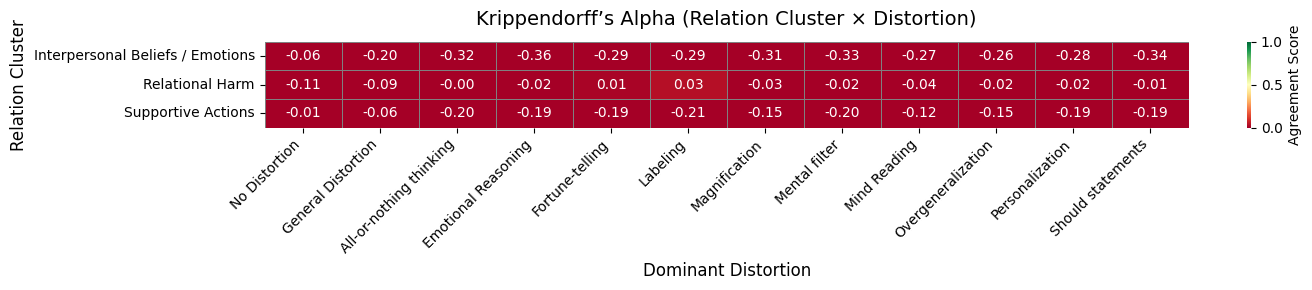

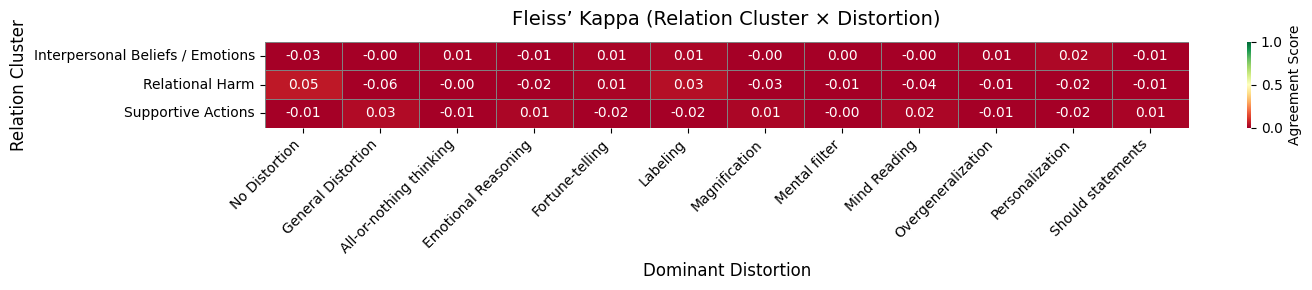

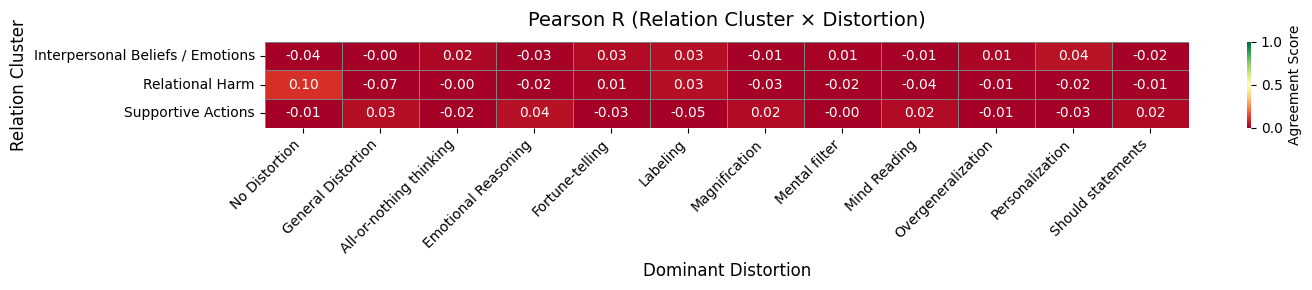

In [9]:
#  Ensure same sorting function is applied
def custom_sort(distortions):
    base = ['No Distortion', 'General Distortion']
    rest = sorted([d for d in distortions if d not in base])
    return base + rest

#  Sorted row and column labels
sorted_rows = sorted(alpha_pivot.index)
sorted_cols = custom_sort(alpha_pivot.columns)

#  Heatmap function
def plot_heatmap(matrix, title, vmin=0.0, vmax=1.0, cmap='RdYlGn', sorted_rows=None, sorted_cols=None):
    if sorted_rows is None:
        sorted_rows = matrix.index
    if sorted_cols is None:
        sorted_cols = custom_sort(matrix.columns)

    matrix_filtered = matrix.loc[sorted_rows, sorted_cols]
    plt.figure(figsize=(len(matrix_filtered.columns) * 1.2, len(matrix_filtered.index) * 1.0))
    sns.heatmap(matrix_filtered,
                xticklabels=matrix_filtered.columns,
                yticklabels=matrix_filtered.index,
                vmin=vmin,
                vmax=vmax,
                cmap=cmap,
                annot=True,
                fmt=".2f",
                linewidths=0.5,
                linecolor='gray',
                cbar_kws={"label": "Agreement Score"})
    plt.title(title, fontsize=14, pad=12)
    plt.xlabel("Dominant Distortion", fontsize=12)
    plt.ylabel("Relation Cluster", fontsize=12) # Keep generic label or change based on matrix index
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

#  Plot the 3 agreement heatmaps
plot_heatmap(alpha_pivot, "Krippendorff’s Alpha (Relation Cluster × Distortion)")
plot_heatmap(kappa_pivot, "Fleiss’ Kappa (Relation Cluster × Distortion)")
plot_heatmap(pearson_pivot, "Pearson R (Relation Cluster × Distortion)")

# Cramer's V Analysis for Layer 1



Cramer's V for Relation Cluster vs Dominant Distortion: 0.1062
Cramer's V for Top Relation Clusters vs Dominant Distortion: 0.1062

Cramer's V Pivot Table (Relation Cluster × Distortion):


Distortion,No Distortion,General Distortion,All-or-nothing thinking,Emotional Reasoning,Fortune-telling,Labeling,Magnification,Mental filter,Mind Reading,Overgeneralization,Personalization,Should statements
Cluster,,,,,,,,,,,,
Interpersonal Beliefs / Emotions,0.035086,0.001127,0.013967,0.028900,0.025596,0.032398,0.009373,0.005764,0.006279,0.013502,0.038809,0.015691
Relational Harm,0.098553,0.070323,0.000000,0.011903,0.004926,0.030745,0.028984,0.010883,0.037121,0.009265,0.016526,0.008561
Supportive Actions,0.005545,0.031881,0.013568,0.036355,0.029469,0.047392,0.023184,0.000000,0.023291,0.008605,0.031026,0.021367


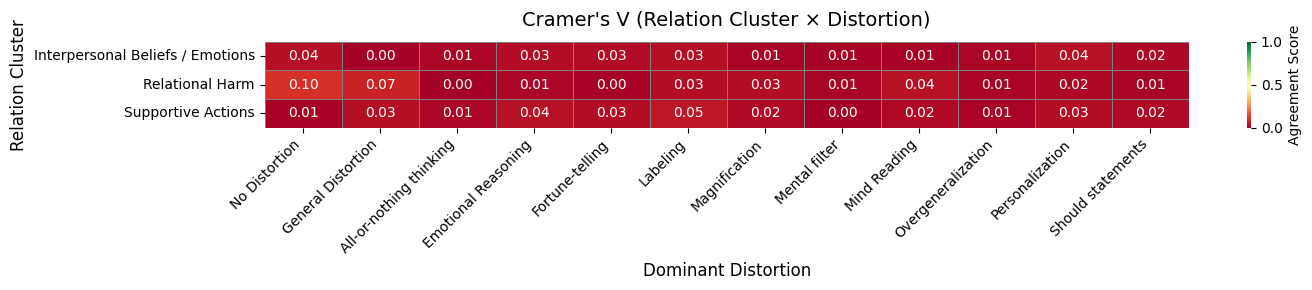

In [10]:
from scipy.stats import chi2_contingency

def cramers_v(contingency_matrix):
  """Calculate Cramer's V for a contingency matrix."""
  chi2 = chi2_contingency(contingency_matrix)[0]
  n = contingency_matrix.sum().sum()
  min_dim = min(contingency_matrix.shape) - 1
  # Avoid division by zero or small numbers
  if min_dim == 0 or n == 0:
      return 0.0
  v = np.sqrt(chi2 / (n * min_dim))
  return v

# Calculate Cramer's V for the Relation Cluster vs Dominant Distortion matrix
contingency_matrix = pd.crosstab(
    triples_df["relation_cluster_label"],
    triples_df["Dominant Distortion"]
)

cramers_v_score = cramers_v(contingency_matrix)
print(f"Cramer's V for Relation Cluster vs Dominant Distortion: {cramers_v_score:.4f}")

# Optional: Calculate Cramer's V for the filtered data (top relation clusters)
contingency_matrix_filtered = pd.crosstab(
    df[df['relation_cluster_label'].isin(top_relation_clusters)]["relation_cluster_label"],
    df[df['relation_cluster_label'].isin(top_relation_clusters)]["Dominant Distortion"]
)

cramers_v_score_filtered = cramers_v(contingency_matrix_filtered)
print(f"Cramer's V for Top Relation Clusters vs Dominant Distortion: {cramers_v_score_filtered:.4f}")

# Optional: Generate Cramer's V matrix for all pairwise combinations
cramers_v_results = []
unique_clusters = triples_df["relation_cluster_label"].unique()
unique_distortions = triples_df["Dominant Distortion"].unique()

# For calculating between cluster and distortion
for cluster in unique_clusters:
    for distortion in unique_distortions:
        # Create a 2x2 contingency table for presence/absence of each category
        contingency_table = pd.crosstab(
            triples_df["relation_cluster_label"] == cluster,
            triples_df["Dominant Distortion"] == distortion
        )
        v_score = cramers_v(contingency_table)
        cramers_v_results.append({
            'Cluster': cluster,
            'Distortion': distortion,
            'Cramers_V': v_score
        })

cramers_v_df = pd.DataFrame(cramers_v_results)

# Create pivot table for visualization
cramers_v_pivot = cramers_v_df.pivot(index='Cluster', columns='Distortion', values='Cramers_V')

# Sort columns using the custom sort function
sorted_cols_cramers = custom_sort(cramers_v_pivot.columns)
cramers_v_pivot = cramers_v_pivot.loc[cramers_v_pivot.index, sorted_cols_cramers]


print("\nCramer's V Pivot Table (Relation Cluster × Distortion):")
display(cramers_v_pivot)

plot_heatmap(cramers_v_pivot, "Cramer's V (Relation Cluster × Distortion)", vmin=0.0, vmax=1.0, cmap='RdYlGn')


## Distribution Analysis of Frequent Relations by Cluster

Frequency Table of Relation Clusters and Top 5 Relations:


relation,love,like,hate,date,help
relation_cluster_label,,,,,
Interpersonal Beliefs / Emotions,568,337,305,0,0
Supportive Actions,0,0,0,244,236


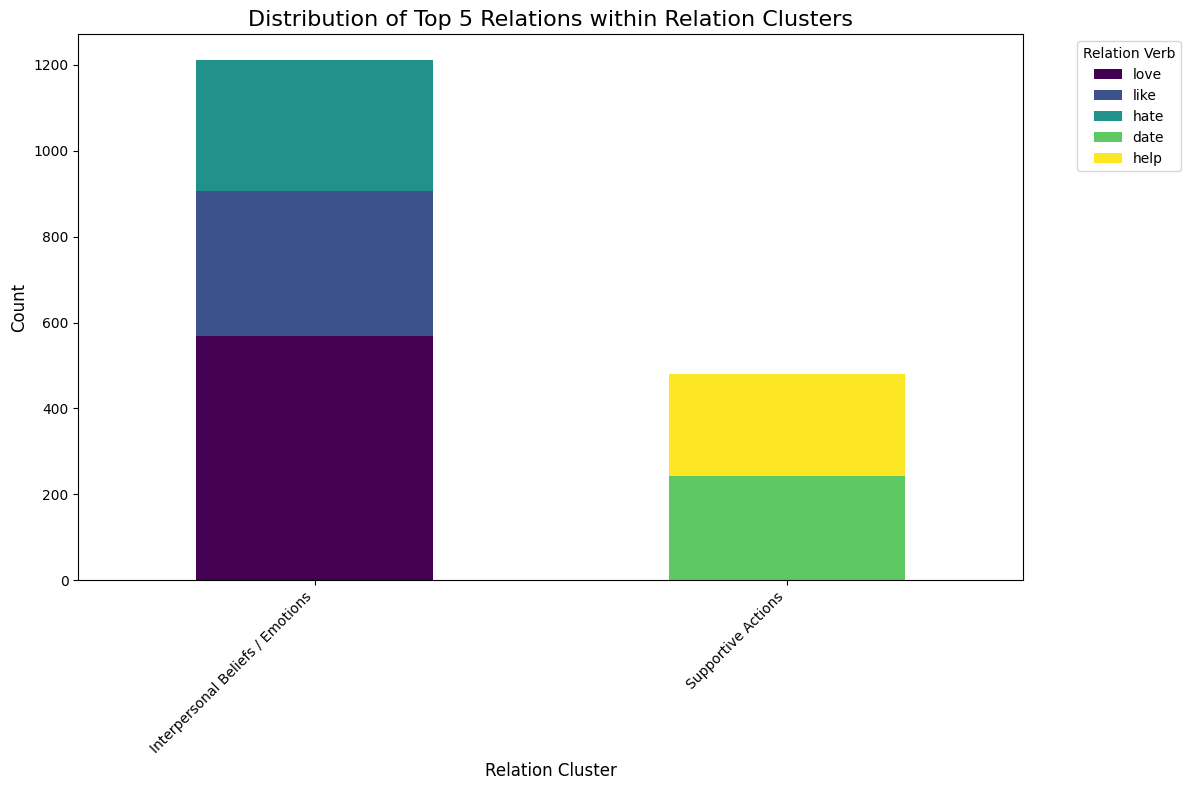

In [11]:
# Get the top 5 most frequent relation verbs across the entire dataset
top_5_relations = triples_df['relation'].value_counts().nlargest(5).index.tolist()

df_top_relations = triples_df[triples_df['relation'].isin(top_5_relations)]

cluster_relation_freq = pd.crosstab(
    index=df_top_relations['relation_cluster_label'],
    columns=df_top_relations['relation']
)

# Ensure all top 5 relations are columns, even if they have zero counts in some clusters
for rel in top_5_relations:
    if rel not in cluster_relation_freq.columns:
        cluster_relation_freq[rel] = 0

# Reorder columns to match the order of top_5_relations
cluster_relation_freq = cluster_relation_freq[top_5_relations]

print("Frequency Table of Relation Clusters and Top 5 Relations:")
display(cluster_relation_freq)

# Plot the stacked bar chart
plt.figure(figsize=(12, 8))
cluster_relation_freq.plot(kind='bar', stacked=True, ax=plt.gca(), cmap='viridis')

plt.title("Distribution of Top 5 Relations within Relation Clusters", fontsize=16)
plt.xlabel("Relation Cluster", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title="Relation Verb", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Top relations and their associated distortions

In [12]:
from collections import Counter

top_verbs = triples_df['relation'].value_counts().nlargest(5).index.tolist()

# 2. Create a frequency table (contingency table) of top relations and distortions

freq_table = pd.crosstab(
    index=triples_df['relation'],
    columns=triples_df['Dominant Distortion']
)

# Filter the frequency table to include only the top 5 verbs
freq_table_top_verbs = freq_table.loc[top_verbs]

print("Frequency Table of Top 5 Verb Relations and Dominant Distortions")
display(freq_table_top_verbs)

distortion_types = triples_df['Dominant Distortion'].unique()
for dist in distortion_types:
    triples_df[f'dist_{dist}'] = (triples_df['Dominant Distortion'] == dist).astype(int)

Frequency Table of Top 5 Verb Relations and Dominant Distortions


Dominant Distortion,All-or-nothing thinking,Emotional Reasoning,Fortune-telling,General Distortion,Labeling,Magnification,Mental filter,Mind Reading,No Distortion,Overgeneralization,Personalization,Should statements
relation,,,,,,,,,,,,
love,20,7,41,60,29,32,13,35,222,53,45,11
like,14,9,10,51,22,15,15,28,117,33,8,15
hate,19,5,18,57,22,27,16,28,68,22,21,2
date,10,5,4,10,5,13,8,20,138,20,6,5
help,12,10,15,22,8,23,4,15,97,13,9,8


## Visualizing Dominant Distortion for Top 5 Relations (Layer 2)

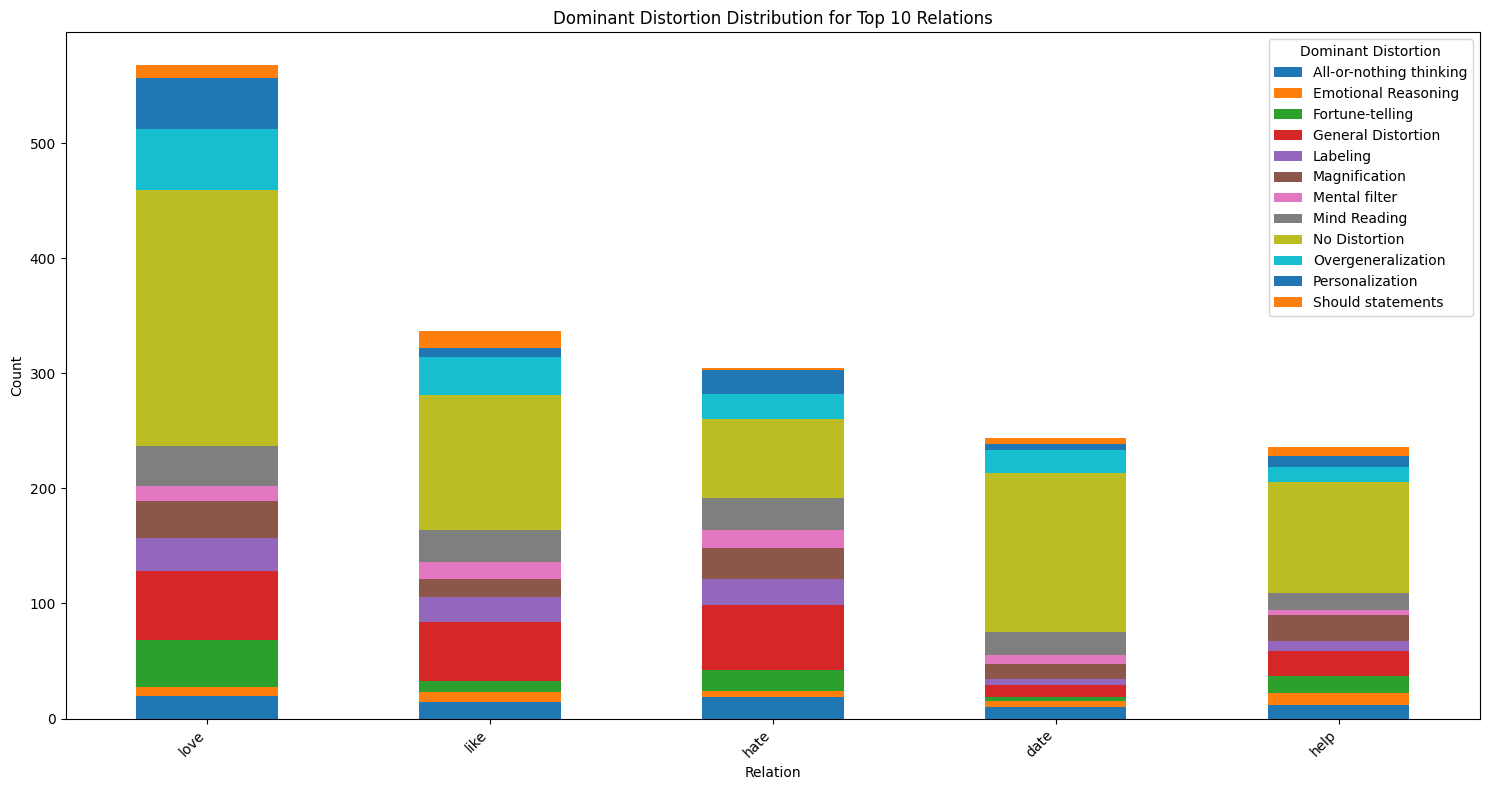

In [13]:
freq_table_top_verbs.plot(kind='bar', stacked=True, figsize=(15, 8))
plt.title("Dominant Distortion Distribution for Top 10 Relations")
plt.xlabel("Relation")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Dominant Distortion")
plt.tight_layout()
plt.show()


# Generating Binary Matrix of Layer 2 relations and Distortions

In [14]:
from scipy.stats import pointbiserialr

# 1. Get top 5 most frequent verb relations
top_relations = triples_df['relation'].value_counts().nlargest(5).index.tolist()

# 2. Get unique distortion types
distortion_types = triples_df['Dominant Distortion'].dropna().unique()

# 3. Create binary columns for each distortion type in a separate DataFrame
distortion_binary_df = pd.DataFrame()
for dist in distortion_types:
    # Corrected: Compare the column to the distortion type and convert boolean result to int
    distortion_binary_df[f'dist_{dist}'] = (triples_df['Dominant Distortion'] == dist).astype(int)

# 4. Generate the binary matrix by concatenating the relevant parts
binary_table = pd.concat([
    triples_df['context'],
    pd.get_dummies(triples_df['relation'])[top_relations].astype(int),
    distortion_binary_df
], axis=1)

print("Binary Matrix of Relations vs. Distortions (0s and 1s)")
display(binary_table.head())

Binary Matrix of Relations vs. Distortions (0s and 1s)


,context,love,like,hate,date,help,dist_General Distortion,dist_No Distortion,dist_Labeling,dist_Magnification,dist_Fortune-telling,dist_Personalization,dist_Mind Reading,dist_Mental filter,dist_Emotional Reasoning,dist_Overgeneralization,dist_All-or-nothing thinking,dist_Should statements
0,Nobody likes me because I'm not interesting.,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,Nobody cares about me because they didn't ask...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,My partner didn't say 'I love you' today our ...,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,I didn't get a reply to my email they must ha...,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,No one will ever love me because I'm too shy.,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


## Inter-Rater Reliability Analysis for Relation-Distortion Pairs

In [17]:
import krippendorff as kd
from statsmodels.stats import inter_rater as irr
from typing import List, Dict, Optional

def calculate_agreement_metrics(
    binary_table: pd.DataFrame,
    relation_cols: List[str],
    distortion_cols: List[str]
) -> pd.DataFrame:

    results = []

    for rel_col in relation_cols:
        for dist_col in distortion_cols:
            # Get clean data (drop NAs and ensure binary values)
            clean_data = binary_table[[rel_col, dist_col]].dropna()

            # Skip if insufficient data
            if len(clean_data) < 2:
                results.append(create_result_entry(rel_col, dist_col, None, None, None))
                continue

            # Prepare data for calculations
            ratings = clean_data.values.T

            # Calculate metrics
            k_alpha = calculate_krippendorff_alpha(ratings)
            f_kappa = calculate_fleiss_kappa(clean_data)
            p_corr = calculate_pearson_correlation(clean_data[rel_col], clean_data[dist_col])

            results.append(create_result_entry(rel_col, dist_col, k_alpha, f_kappa, p_corr))

    return pd.DataFrame(results)

def calculate_krippendorff_alpha(ratings: np.ndarray) -> Optional[float]:
    """Calculate Krippendorff's Alpha with error handling."""
    try:
        return kd.alpha(
            reliability_data=ratings,
            level_of_measurement='nominal'
        )
    except (ValueError, ZeroDivisionError):
        return np.nan

def calculate_fleiss_kappa(data: pd.DataFrame) -> Optional[float]:
    """Calculate Fleiss' Kappa with error handling."""
    try:
        # Create aggregated counts for each category (0 and 1)
        agg_counts = np.zeros((len(data), 2), dtype=int)
        agg_counts[:, 0] = (data == 0).sum(axis=1)
        agg_counts[:, 1] = (data == 1).sum(axis=1)

        return irr.fleiss_kappa(agg_counts, method='fleiss')
    except (ValueError, ZeroDivisionError):
        return np.nan

def calculate_pearson_correlation(
    series1: pd.Series,
    series2: pd.Series
) -> Optional[float]:
    """Calculate Pearson correlation with validation checks."""
    try:
        if series1.nunique() > 1 and series2.nunique() > 1:
            return series1.corr(series2)
        return np.nan
    except (ValueError, RuntimeWarning):
        return np.nan

def create_result_entry(
    relation: str,
    distortion: str,
    k_alpha: Optional[float],
    f_kappa: Optional[float],
    p_corr: Optional[float]
) -> Dict[str, Optional[float]]:
    """Create standardized result dictionary for each pair."""
    return {
        'Relation': relation,
        'Distortion Type': distortion.replace('dist_', ''),
        'Krippendorff Alpha': k_alpha,
        'Fleiss Kappa': f_kappa,
        'Pearson R': p_corr
    }

# Example usage
if __name__ == "__main__":
    # Load your binary data
    # binary_table = pd.read_csv('binary_data.csv')

    # Define your columns
    # Corrected 'dove' to 'love'
    relation_cols = ['love', 'like', 'hate', 'date', 'help']
    distortion_cols = [col for col in binary_table.columns if col.startswith('dist_')]

    # Calculate metrics
    results_df = calculate_agreement_metrics(
        binary_table=binary_table,
        relation_cols=relation_cols,
        distortion_cols=distortion_cols
    )

    # Display results
    print("Agreement Metrics Results:")
    pd.set_option('display.float_format', '{:.3f}'.format)
    display(results_df.head())
    display(results_df.tail())

    # save results
    # results_df.to_csv('agreement_metrics_results.csv', index=False)

Agreement Metrics Results:


,Relation,Distortion Type,Krippendorff Alpha,Fleiss Kappa,Pearson R
0,love,General Distortion,-0.040,-0.040,-0.038
1,love,No Distortion,-0.053,-0.054,0.004
2,love,Labeling,-0.033,-0.033,0.008
3,love,Magnification,-0.030,-0.030,0.006
4,love,Fortune-telling,-0.001,-0.001,0.041


,Relation,Distortion Type,Krippendorff Alpha,Fleiss Kappa,Pearson R
55,help,Mental filter,-0.030,-0.030,-0.024
56,help,Emotional Reasoning,0.015,0.015,0.030
57,help,Overgeneralization,-0.021,-0.021,-0.021
58,help,All-or-nothing thinking,0.016,0.016,0.024
59,help,Should statements,-0.003,-0.003,0.006


## Creating pivot table and heatmap for each metric


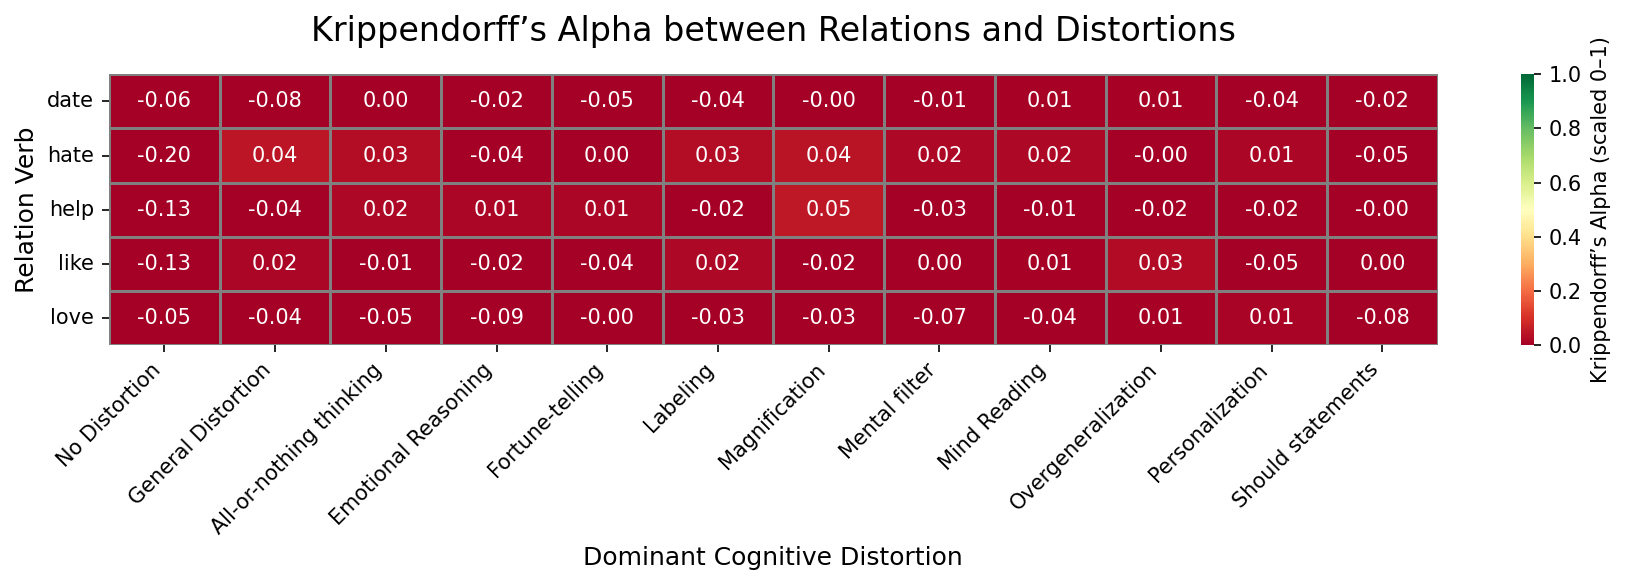

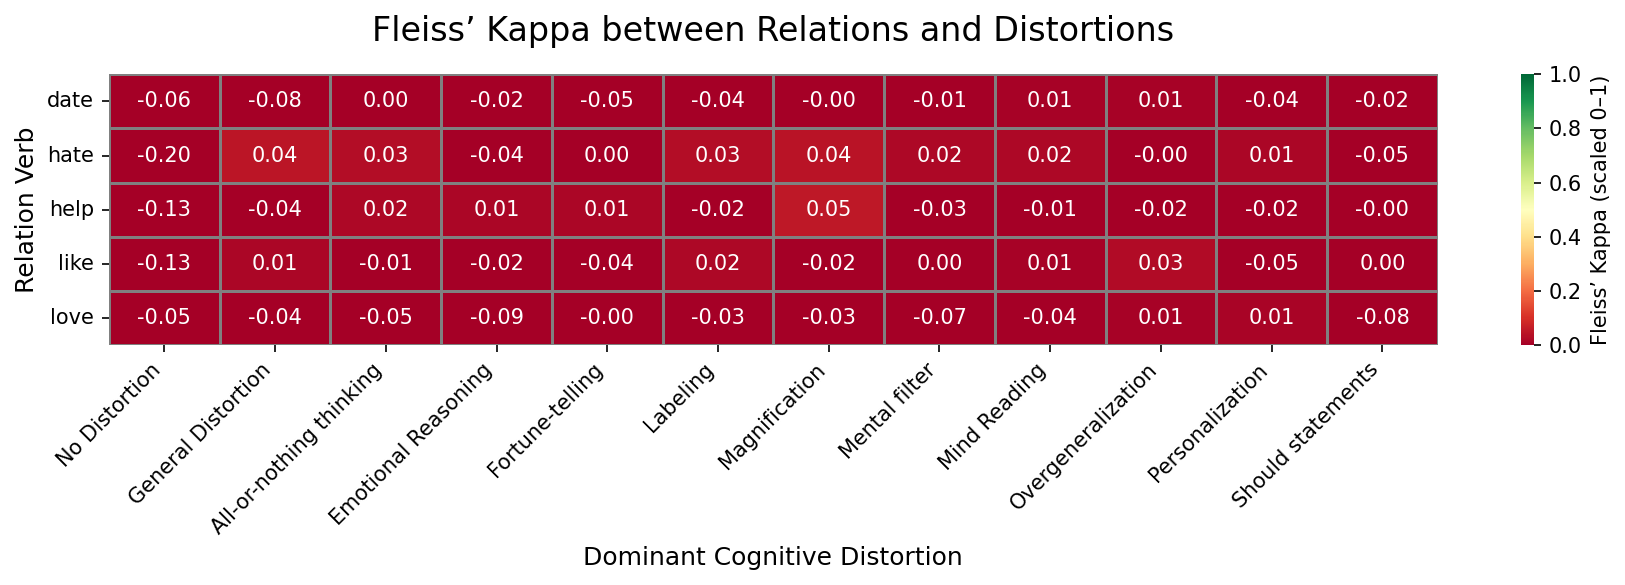

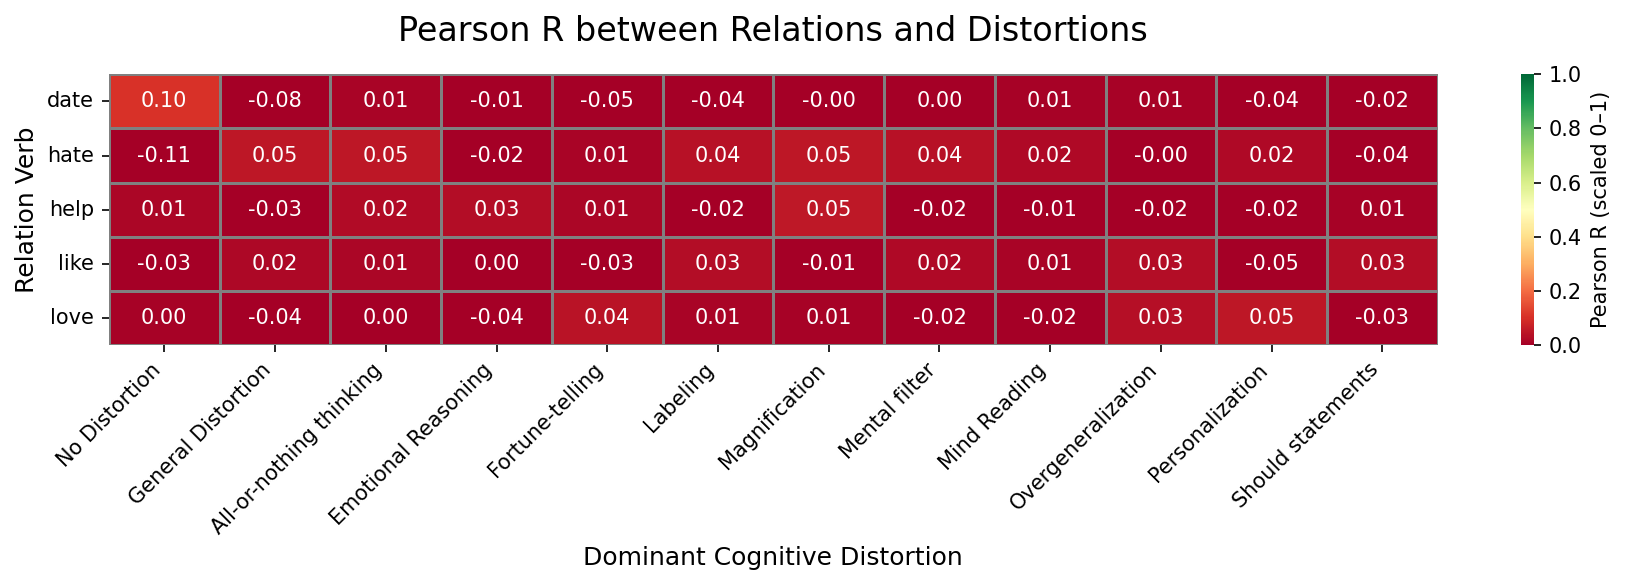

In [18]:
# Create pivot tables for each metric
alpha_pivot = results_df.pivot(index='Relation', columns='Distortion Type', values='Krippendorff Alpha')
kappa_pivot = results_df.pivot(index='Relation', columns='Distortion Type', values='Fleiss Kappa')
pearson_pivot = results_df.pivot(index='Relation', columns='Distortion Type', values='Pearson R')

# Sort distortions as: No..., General..., then rest alphabetically
def custom_sort(distortions):
    base = ['No Distortion', 'General Distortion']
    rest = sorted([d for d in distortions if d not in base])
    return base + rest

# Apply sorting
sorted_rows = sorted(alpha_pivot.index)
sorted_cols = custom_sort(alpha_pivot.columns)

# Sort all pivot tables consistently
alpha_pivot = alpha_pivot.loc[sorted_rows, sorted_cols]
kappa_pivot = kappa_pivot.loc[sorted_rows, sorted_cols]
pearson_pivot = pearson_pivot.loc[sorted_rows, sorted_cols]
def plot_agreement_heatmap(matrix, title, metric_name, vmin=0.0, vmax=1.0, cmap='RdYlGn'):
    plt.figure(figsize=(len(matrix.columns)*1.0, len(matrix.index)*0.8), dpi=150)
    sns.heatmap(matrix,
                xticklabels=matrix.columns,
                yticklabels=matrix.index,
                vmin=vmin,
                vmax=vmax,
                cmap=cmap,
                annot=True,
                fmt=".2f",
                linewidths=0.5,
                linecolor='gray',
                cbar_kws={'label': f"{metric_name} (scaled 0–1)"})
    plt.title(title, fontsize=16, pad=16)
    plt.xlabel('Dominant Cognitive Distortion', fontsize=12)
    plt.ylabel('Relation Verb', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout()
    plt.show()

# Krippendorff’s Alpha
plot_agreement_heatmap(
    alpha_pivot,
    "Krippendorff’s Alpha between Relations and Distortions",
    "Krippendorff’s Alpha"
)

# Fleiss' Kappa
plot_agreement_heatmap(
    kappa_pivot,
    "Fleiss’ Kappa between Relations and Distortions",
    "Fleiss’ Kappa"
)

# Pearson Correlation
plot_agreement_heatmap(
    pearson_pivot,
    "Pearson R between Relations and Distortions",
    "Pearson R"
)

# Cramer's V Analysis


Cramer's V Pivot Table (Top Relations × Distortion):


Distortion Type,No Distortion,General Distortion,All-or-nothing thinking,Emotional Reasoning,Fortune-telling,Labeling,Magnification,Mental filter,Mind Reading,Overgeneralization,Personalization,Should statements
Relation,,,,,,,,,,,,
date,0.103,0.075,0.006,0.005,0.043,0.033,0.000,0.000,0.005,0.005,0.034,0.013
hate,0.106,0.048,0.045,0.015,0.008,0.035,0.047,0.033,0.018,0.001,0.018,0.041
help,0.013,0.031,0.021,0.026,0.012,0.015,0.052,0.021,0.010,0.019,0.017,0.002
like,0.026,0.016,0.010,0.000,0.032,0.026,0.011,0.020,0.008,0.027,0.043,0.025
love,0.003,0.036,0.000,0.035,0.040,0.006,0.004,0.022,0.022,0.030,0.049,0.027


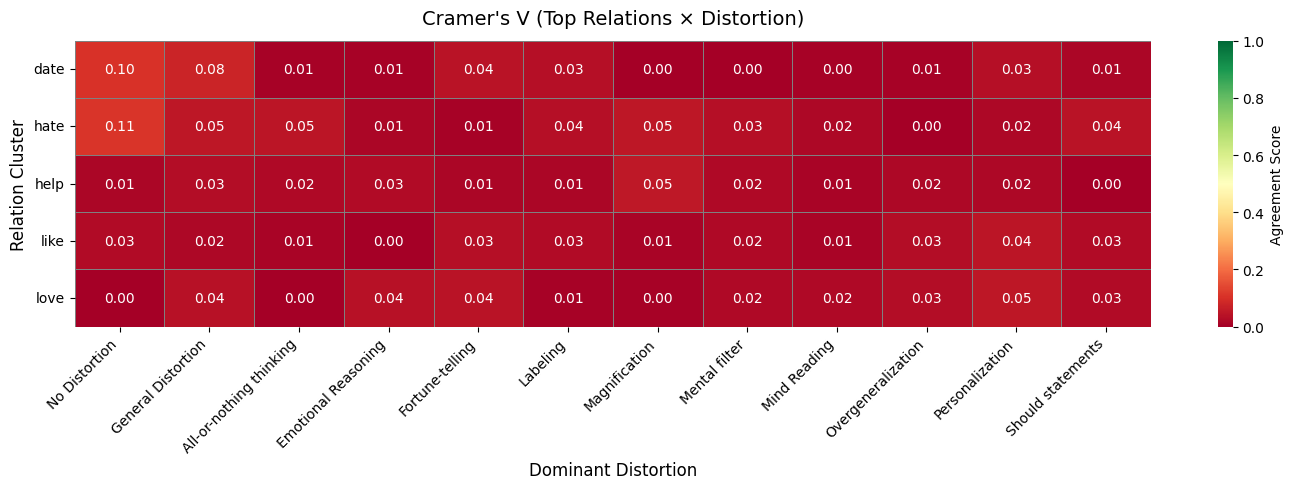

In [19]:
cramers_v_binary_results = []

for rel_col in top_relations_cols:
    for dist_col in distortion_types_cols:
        # Create a 2x2 contingency table for presence/absence of each category
        contingency_table_binary = pd.crosstab(
            binary_table[rel_col],
            binary_table[dist_col]
        )
        v_score = cramers_v(contingency_table_binary)
        cramers_v_binary_results.append({
            'Relation': rel_col,
            'Distortion Type': dist_col.replace('dist_', ''), # Clean up distortion names
            'Cramers_V': v_score
        })

cramers_v_binary_df = pd.DataFrame(cramers_v_binary_results)

# Create pivot table for visualization
cramers_v_binary_pivot = cramers_v_binary_df.pivot(index='Relation', columns='Distortion Type', values='Cramers_V')

# Sort columns using the custom sort function (defined in a previous cell)
sorted_cols_cramers_binary = custom_sort(cramers_v_binary_pivot.columns)
cramers_v_binary_pivot = cramers_v_binary_pivot.loc[cramers_v_binary_pivot.index, sorted_cols_cramers_binary]

print("\nCramer's V Pivot Table (Top Relations × Distortion):")
display(cramers_v_binary_pivot)

# Sort rows for plotting
sorted_rows_cramers_binary = sorted(cramers_v_binary_pivot.index)

# Plot the heatmap for Cramer's V for relations vs distortions
plot_heatmap(cramers_v_binary_pivot, "Cramer's V (Top Relations × Distortion)", vmin=0.0, vmax=1.0, cmap='RdYlGn', sorted_rows=sorted_rows_cramers_binary, sorted_cols=sorted_cols_cramers_binary)